In [ ]:
import pandas as pd
import numpy as np
!pip install emoji
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import itertools
from difflib import get_close_matches
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
import json
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mukun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mukun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mukun\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mukun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mukun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def read_data():
  df = pd.read_csv('Dataset.csv')
  print(df.head())
  return df

def make_arrays(df):
  input_tweets = np.array(df['PlainText'])
  output = np.array(df['Annotation'])
  return input_tweets,output

In [ ]:
def substitute_emoji(input_tweets):
  for i in range(len(input_tweets)):
    tweet = input_tweets[i]
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    input_tweets[i] = tweet

In [ ]:
# function for remove functions and make lowercase
def remove_punctuations(input_tweets):
  contractions = None
  with open('contraction.json',"r") as file:
      contraction_mapping = json.load(file)
  for i in range(len(input_tweets)):
    reddit_tweet = input_tweets[i].replace("’","'")        
    text =re.sub("[^a-zA-Z']|\[[0-9]*\]|[\d]|[\s+]", ' ', input_tweets[i])
    text = re.sub(r'\s+',' ',text)
    text = text.lower()
    input_tweets[i] = text

In [ ]:
def remove_slangs(input_tweets):
    
    abbr = None
    with open('Abbreviations_final.json',"r") as file:
        abbr = json.load(file)   
    for i in range(len(input_tweets)):
        tweet = input_tweets[i].split(' ')
        
        newd = []
        for word in tweet:
            
            if word in abbr:
                s = abbr[word]
                s = s.split(' ')
                newd.extend(s)
            else:
                newd.append(word)
        input_tweets[i] = ' '.join(newd)

def remove_contractions_and_stopwords_lemmatize(input_tweets):
    contractions = None
    lemmatizer = WordNetLemmatizer()
    with open('contraction.json',"r") as file:
        contractions = json.load(file)
        
    for i in range(len(input_tweets)):
        tweet = input_tweets[i].split(' ')
        
        newd = []
        for word in tweet:
            
            if word in contractions:
                s = contractions[word]
                s = s.split(' ')
                newd.extend(s)
            else:
                newd.append(word)
        

        message = [lemmatizer.lemmatize(word) for word in newd if word not in set(stopwords.words('english'))]
        
        input_tweets[i] = ' '.join(message)
        input_tweets[i] = re.sub(r"'",'', input_tweets[i])


    

In [ ]:
df = read_data()
input_tweets,output = make_arrays(df)


                                           PlainText Annotation
0  See the Note: We don't serve People of Doubtfu...          U
1  SIO DELHI WELCOMES THE DELHI COURTS’ DECISION ...          S
2  Gandhi Godse - This is the biggest propoganda ...          U
3  My brother is in jail for three years & during...          U
4  OCI card holder not allowed to enter India, he...          N


In [ ]:
count_dict = {}
max_len = 0
for ele in df['Annotation']:
    
    if ele in count_dict:
        count_dict[ele]+=1
    else:
        count_dict[ele] = 1
count_dict

{'U': 132, 'S': 183, 'N': 578}

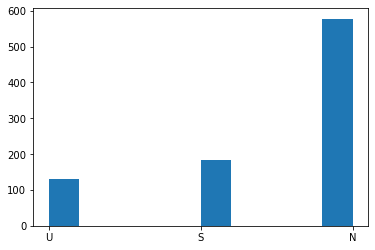

{'U': 132, 'S': 183, 'N': 578}


In [ ]:
plt.hist(df['Annotation'])
plt.show() 
print(count_dict)

In [ ]:
substitute_emoji(input_tweets)
remove_punctuations(input_tweets)
remove_slangs(input_tweets)
remove_contractions_and_stopwords_lemmatize(input_tweets)

In [ ]:
for tweets in input_tweets:
  print(tweets)

see note serve people doubtful citizenship illegal immigrant much disgusting get people nrc assam could brazenly legitimise exclusion public place imagine become country caa nrc implemented 
sio delhi welcome delhi court decision discharge sharjeel imam asif iqbal tanha sioindia siodelhi siojamia siojmi protest caa nrc npr delhi justice asifiqbaltanha sharjeelimam
gandhi godse biggest propoganda movie ever seen director movie rajkumar santoshi biggest leftist aginst caa nrc concept radicalized hindutva v big hearted secular leader gandhigodseekyudh
brother jail three year time several caa nrc activist tried shift blame like several leader threw others bus british raj facing horror prison yearsofinjustice freesharjeelimam
oci card holder allowed enter india oci caa nrc documentary viralvideo blacklisted indian news documentary viral
 drsjaishankar pmoindia always silent still waiting caa nrc hindu targeted everyday bangladesh pakistan see sharp response 
today iffr sab changa si teresa 

In [ ]:
for sentence in input_tweets:
    x = sentence.split(' ')
    max_len = max(max_len,len(x))
print('Max Legth of the feature vector is : ',max_len)

Max Legth of the feature vector is :  229


Synonym Replacement

In [ ]:
from nltk.corpus import wordnet 
import random

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [ ]:
def synonym_replacement(words, n):
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence


In [ ]:
syn_list=[]
for sentence in input_tweets:
    syn_list.append(synonym_replacement(sentence, 1))
    syn_list.append(synonym_replacement(sentence, 2))
    syn_list.append(synonym_replacement(sentence, 3))
    syn_list.append(synonym_replacement(sentence, 4))

len(syn_list)

136

In [ ]:
for sentence in input_tweets:
    syn_list.append(sentence)
    

syn_list=set(syn_list)
len(syn_list)

163

In [ ]:
syn_list

{' yogi ke raaj ek musalman bhai apni muslim rishtedar bacchi ka rape bhi kar sauca ',
 'ab yogi berra ke raaj mein ek musalman bhai apni islamic rishtedar bacchi ka rape bhi nahi kar sakta girl would come pasmanda assort',
 'ab yogi ke raaj mein ek musalman bhai apni islamic rishtedar bacchi ka outrage bhi nahi kar sakta girl would come pasmanda class',
 'ab yogi ke raaj mein ek musalman bhai apni islamic rishtedar bacchi ka ravish bhi nahi kar sakta fille would come up pasmanda class',
 'ab yogi ke raaj mein ek musalman bhai apni muslim rishtedar bacchi ka dishonour bhi nahi kar sakta little girl would come pasmanda socio economic class',
 'ab yogi ke raaj mein ek musalman bhai apni muslim rishtedar bacchi ka rape bhi nahi kar sakta girl would come pasmanda class ',
 'ab yogi ke raaj mein ek musalman bhai apni muslim rishtedar bacchi ka rape bhi nahi kar sakta girl would come pasmanda family',
 'ab yogi ke raaj mein ek musalman bhai apni muslim rishtedar bacchi ka rape bhi nahi kar s

In [ ]:
data1 = pd.DataFrame(data=syn_list)

In [ ]:
final_df = pd.DataFrame(list(zip(input_tweets, output)),columns =['PlainText', 'Annotation'])
final_df

,PlainText,Annotation
0,see note serve people doubtful citizenship ill...,U
1,sio delhi welcome delhi court decision dischar...,S
2,gandhi godse biggest propoganda movie ever see...,U
3,brother jail three year time several caa nrc a...,U
4,oci card holder allowed enter india oci caa nr...,N
...,...,...
888,restriction go hand hand unsubstantiated rumor...,N
889,announce first think later,N
890,refreshing see handle orgasm awesome every sin...,N
891,laughing loud street level thug operate might ...,N


In [ ]:
final_df = final_df[final_df.Annotation != -1]
final_df

,Reviews,Category
0,sir automatic toll collection carried using fa...,1
1,contd world class need charging station solar ...,1
2,integrated app must designed integrated toll f...,1
3,recently saw one bike rider lying spot dead si...,1
4,integrated app must designed information ameni...,1
...,...,...
518,good idea,0
519,good way progress country feel proud,0
520,super investment,0
521,sir please hmare bhi sunwal kare,0


In [ ]:
final_df.to_csv('processed_data.csv')

In [ ]:
df = pd.read_csv('processed_data.csv')

In [ ]:
i=0
for ele in df['PlainText']:
    ele=ele.strip()
    if ele is '':
        print(i)
    i+=1

In [ ]:
count_dict = {}
max_len = 0
for ele in df['Annotation']:
    
    if ele in count_dict:
        count_dict[ele]+=1
    else:
        count_dict[ele] = 1
count_dict

{'U': 132, 'S': 183, 'N': 578}

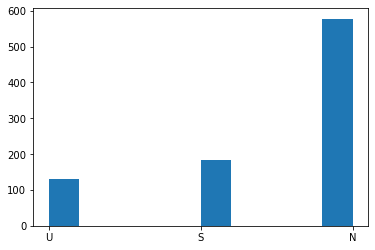

{'U': 132, 'S': 183, 'N': 578}


In [ ]:
plt.hist(df['Annotation'])
plt.show() 
print(count_dict)

In [ ]:
df, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

input_tweets,output = make_arrays(df)
print(df)
print(test)

                                               Reviews  Category
470  mandatory company buy back eee predefined rate...         1
6    intelligent person saw comment must see attach...         0
104  wonderful thing like formation sector skill co...         1
114  thousand black spot accident prone spot differ...         1
478                              movieswood movie wood         0
..                                                 ...       ...
71   pradhan mantri fasal bima yojana pmfby launche...         1
106  suggestion invest creating vast pool rightly s...         1
270  respected sir please help minority excel india...         1
435  sir would like suggest good opportunity govt i...         1
102  weapon development army development public ris...         1

[500 rows x 2 columns]
                                               Reviews  Category
448  nhai organisation bulid road manage safety wel...         1
486  need open cycle unit lifting counter garbbage ...         1
2

In [ ]:
for sentence in input_tweets:
    x = sentence.split(' ')
    max_len = max(max_len,len(x))
print('Max Legth of the feature vector is : ',max_len)

Max Legth of the feature vector is :  168


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

In [ ]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(input_tweets)
X = traindata
y = df.Annotation

In [ ]:
print(X)
print(X.shape)

  (0, 8933)	1
  (0, 2541)	2
  (0, 1786)	1
  (0, 1063)	1
  (0, 4197)	1
  (0, 11525)	1
  (0, 12138)	1
  (0, 16417)	1
  (0, 8198)	1
  (0, 10006)	2
  (0, 15732)	2
  (0, 11695)	1
  (0, 6207)	2
  (0, 3514)	1
  (0, 8654)	1
  (0, 4026)	1
  (0, 15771)	1
  (0, 9912)	2
  (0, 13947)	1
  (0, 6337)	1
  (0, 9334)	1
  (0, 16213)	1
  (0, 12508)	1
  (0, 10818)	1
  (0, 2101)	2
  :	:
  (498, 12542)	1
  (498, 14083)	1
  (498, 10742)	1
  (498, 7916)	1
  (498, 11798)	1
  (498, 5563)	1
  (498, 5053)	1
  (498, 14850)	1
  (498, 5587)	1
  (498, 10897)	1
  (498, 9095)	1
  (498, 5310)	1
  (498, 2508)	1
  (499, 3590)	2
  (499, 772)	1
  (499, 11900)	1
  (499, 5446)	1
  (499, 16334)	1
  (499, 12713)	1
  (499, 16335)	1
  (499, 3591)	1
  (499, 775)	1
  (499, 3609)	1
  (499, 11913)	1
  (499, 12714)	1
(500, 16813)


In [ ]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1500}

In [ ]:
for i in range(432):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': 5, 'max_f

Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 1000}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 1500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.6278257802856639


Rank:  405
Parameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1500}
Mean Test Score:  0.6259389878328336
Rank:  405
Parameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Mean Test Score:  0.6259389878328336
Rank:  405
Parameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
Mean Test Score:  0.6259389878328336
Rank:  405
Parameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1500}
Mean Test Score:  0.6278257802856639
Rank:  73
Parameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Mean Test Score:  0.6259389878328336
Rank:  405
Parameters:  {'bootstrap': F

In [ ]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X,y)

In [ ]:
rfc = RandomForestClassifier(max_features='sqrt', 
                             n_estimators=1500,
                             min_samples_split=10, 
                             min_samples_leaf=2, 
                             bootstrap=True,
                             class_weight={-1:2,0:2,1:1})
rfc.fit(X,y)

RandomForestClassifier(class_weight={-1: 2, 0: 2, 1: 1}, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1500)

In [ ]:
X_test,y_test = test.PlainText,test.Annotation
test_df = y_test
#pre-processing of text
test_corpus = X_test
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

Accuracy_score:  0.8195488721804511
Precision_score:  0.8195488721804511
Recall_score:  0.8195488721804511
--------------------------------------------------
              precision    recall  f1-score   support

          -1       1.00      0.82      0.90        28
           0       0.73      0.79      0.76        47
           1       0.83      0.84      0.84        58

    accuracy                           0.82       133
   macro avg       0.85      0.82      0.83       133
weighted avg       0.83      0.82      0.82       133



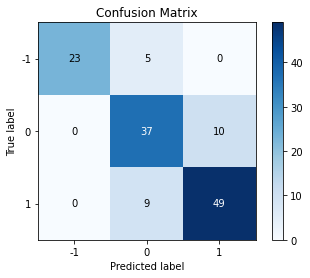

In [ ]:
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions,average='micro')
rec_score = recall_score(y_test,predictions,average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)